# ID1: 315074310
# ID2: 208462077

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler,RobustScaler, QuantileTransformer,PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_log_error


# Reset warning filters (optional)
warnings.resetwarnings()
warnings.filterwarnings('ignore')
# Better display the output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


/Users/urisegman/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Uploading the Data

In [2]:
demand_df = pd.read_csv('demand.csv')
print(f'demand df shape is {demand_df.shape}')
fulfilment_df = pd.read_csv('fulfilment_center_info.csv')
print(f'fullfilment df shape is {fulfilment_df.shape}')
meal_df = pd.read_csv('meal_info.csv')
print(f'meal df shape is {meal_df.shape}')

display(demand_df.head(5))
print(f'demand df has {demand_df.isna().sum().sum()} nas')

display(fulfilment_df.head(5))
print(f'fulfilment df has {fulfilment_df.isna().sum().sum()} nas')

display(meal_df.head(5))
print(f'meal df has {meal_df.isna().sum().sum()} nas')

demand df shape is (456548, 9)
fullfilment df shape is (77, 5)
meal df shape is (51, 3)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


demand df has 0 nas


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


fulfilment df has 0 nas


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


meal df has 0 nas


### None of the data has Na's: We are moving to EDA

# EDA
In the EDA part we began by combining the data, so we can look at relationships between the features accross the 3 df's

## Because the Fullfillment df was full of categoricals, we looked at creating numeric features that represent the geographic values of these categories. Initially we did this during the EDA, but we will start off with it for easier representation and investigation 

In [3]:
'''creating for each region and city a value that represents the extent of the Company's distribution 
in specific regions by counting the number of running centers they have'''

fulfilment_df['region_center_count'] = fulfilment_df.groupby('region_code')['center_id'].transform('count')
fulfilment_df['city_center_count'] = fulfilment_df.groupby('city_code')['center_id'].transform('count')
fulfilment_df['region_city_count'] = fulfilment_df.groupby('region_code')['city_code'].transform('nunique')


## Joinig the Dataframes on shared keys

In [4]:
combined_df = pd.merge(demand_df, fulfilment_df, on='center_id', how='left')
combined_df = pd.merge(combined_df, meal_df,  on='meal_id', how='left')
combined_df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area,region_center_count,city_center_count,region_city_count
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590,21.840735,2.951749,13.336072
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686,8.619282,2.991564,4.459776
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000,1.000000,1.000000,1.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000,17.000000,1.000000,12.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000,21.000000,1.000000,16.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000,30.000000,3.000000,16.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000,30.000000,9.000000,16.000000


# <font color=blue> Data Exploration
The Big question we began trying to investigate was how will we treat time??

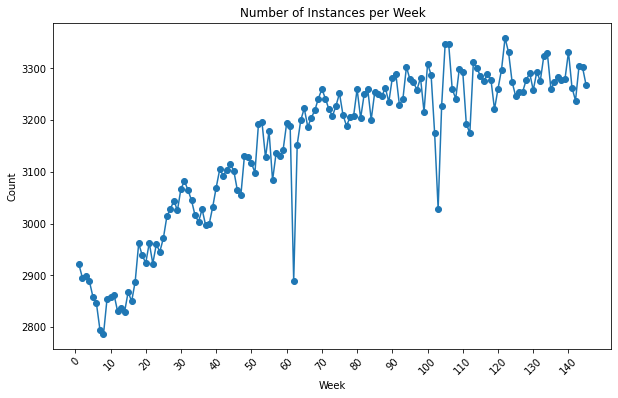

In [5]:
# Count instances in each week
week_counts = combined_df['week'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
week_counts.plot(kind='line', marker='o')
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Number of Instances per Week')
plt.xticks(range(0, len(week_counts), 10), rotation=45)
plt.show()


This graph shows that the number of meals sold has increased over time, meaning the company is growing. There are some anomolies of drops around week 60 and 115 (almost exacctlty the following year!) which may mean there is relevance to previous year orders

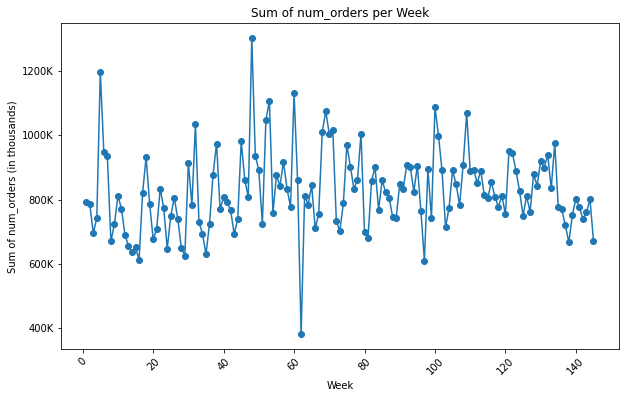

In [6]:
weekly_sum = combined_df.groupby('week')['num_orders'].sum()

# Define a formatter function to display y-axis values in thousands
def thousands_formatter(x, pos):
    """Formatter function to display values in thousands"""
    return '{:.0f}K'.format(x * 1e-3)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weekly_sum.index, weekly_sum.values, marker='o')
plt.xlabel('Week')
plt.ylabel('Sum of num_orders (in thousands)')
plt.title('Sum of num_orders per Week')
plt.xticks(rotation=45)

# Apply the formatter function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()

This is the sum of total orders. We see that while number of items sold has increased, the trend is not so clearly visible in terms of actual order numbers (maybe indicating they have not increased their market share?)

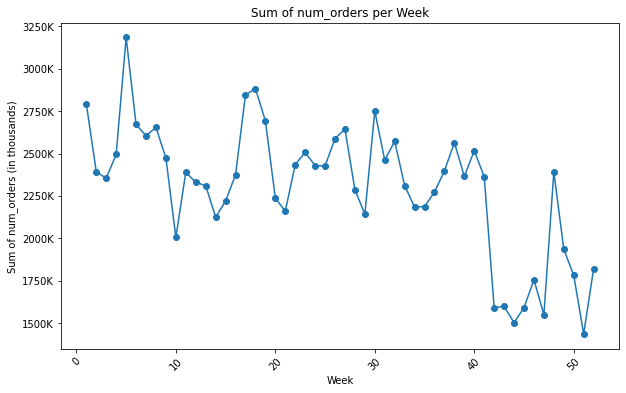

In [7]:
combined_df['week_of_year'] = (combined_df['week'] - 1) % 52 + 1
# we also looked at the importance of the cyclicality of the year:
weekly_sum = combined_df.groupby('week_of_year')['num_orders'].sum()

# Define a formatter function to display y-axis values in thousands
def thousands_formatter(x, pos):
    """Formatter function to display values in thousands"""
    return '{:.0f}K'.format(x * 1e-3)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weekly_sum.index, weekly_sum.values, marker='o')
plt.xlabel('Week')
plt.ylabel('Sum of num_orders (in thousands)')
plt.title('Sum of num_orders per Week')
plt.xticks(rotation=45)

# Apply the formatter function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.show()


There is a drop between week 42-52 because there is 3 years minus 10 weeks of data in the table

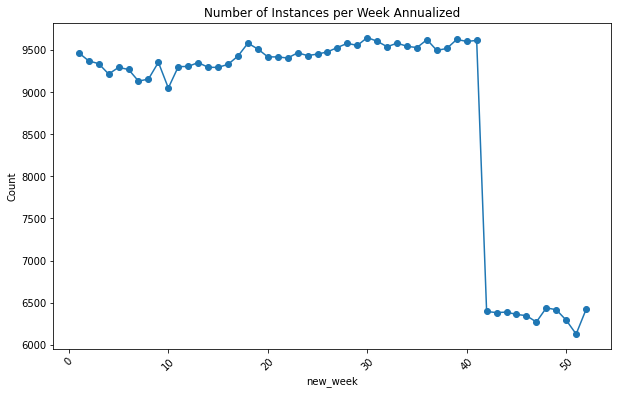

In [8]:
week_counts = combined_df['week_of_year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
week_counts.plot(kind='line', marker='o')
plt.xlabel('new_week')
plt.ylabel('Count')
plt.title('Number of Instances per Week Annualized')
plt.xticks(range(0, len(week_counts), 10), rotation=45)
plt.show()


During this investigation of annuality and time we reached no conclusive understanding of how time as a feature of its own will effect the prediction, we continued to look at other features and consider their distibution relative to itself and relative to the target varriable

In [9]:
for col in combined_df.columns:
    print(f'{col}: {combined_df[col].nunique()} unique values')
combined_df = combined_df.drop(columns=['id','week_of_year'])

id: 456548 unique values
week: 145 unique values
center_id: 77 unique values
meal_id: 51 unique values
checkout_price: 1992 unique values
base_price: 1907 unique values
emailer_for_promotion: 2 unique values
homepage_featured: 2 unique values
num_orders: 1250 unique values
city_code: 51 unique values
region_code: 8 unique values
center_type: 3 unique values
op_area: 30 unique values
region_center_count: 5 unique values
city_center_count: 5 unique values
region_city_count: 4 unique values
category: 14 unique values
cuisine: 4 unique values
week_of_year: 52 unique values


We remove id and week of year because no info gain in them

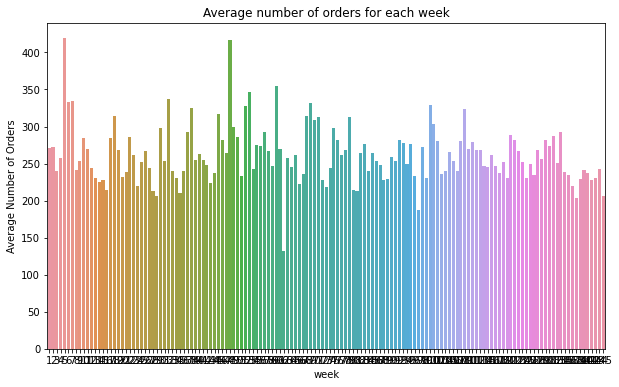

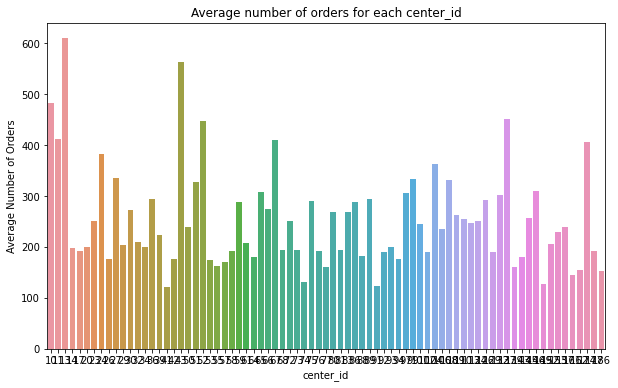

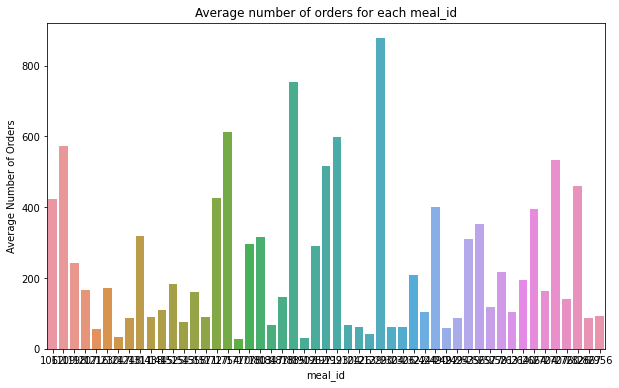

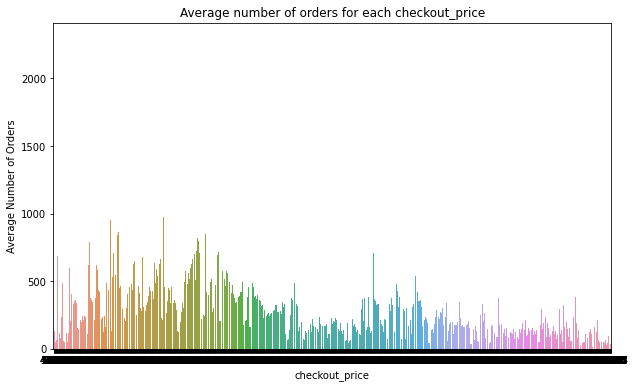

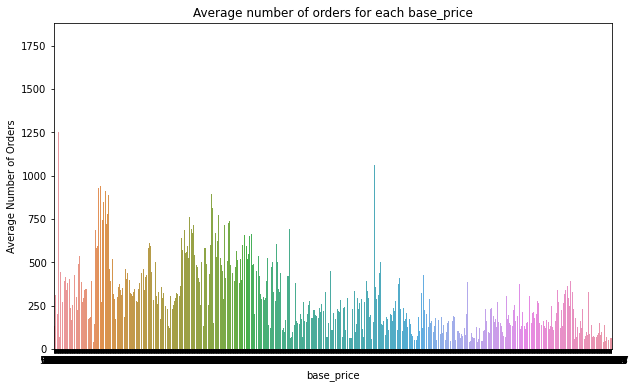

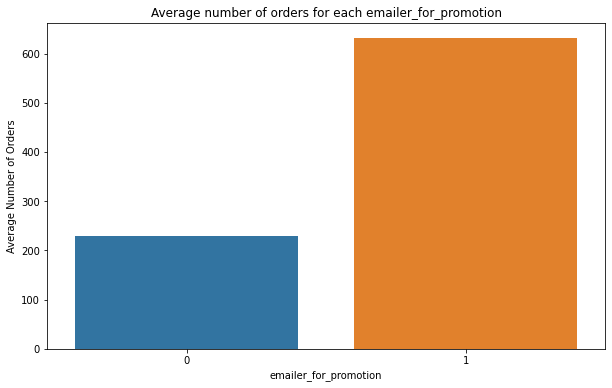

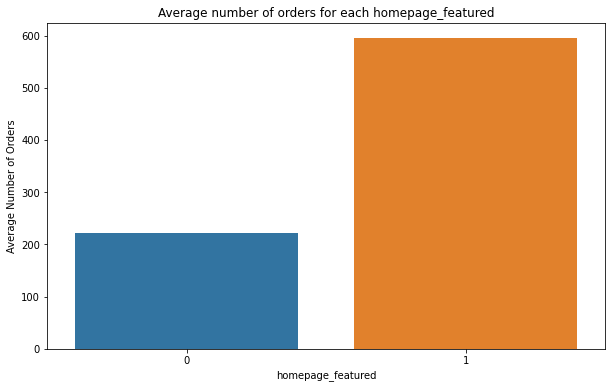

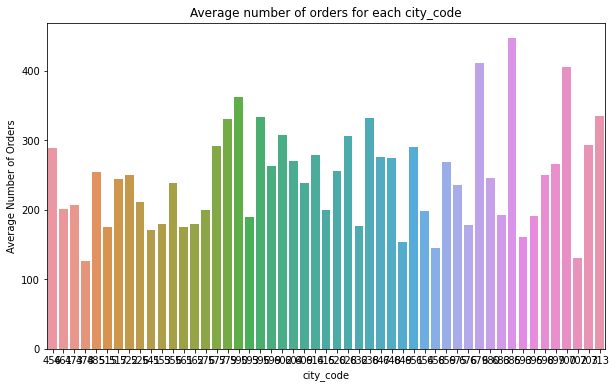

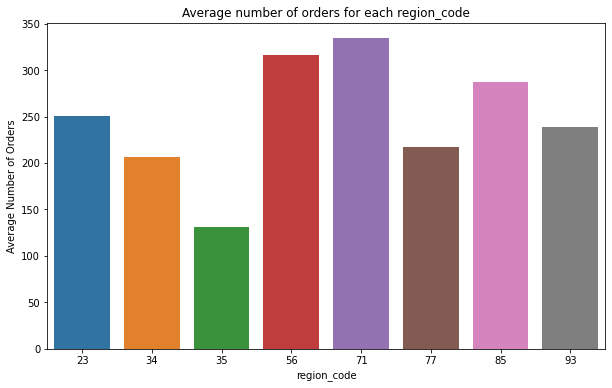

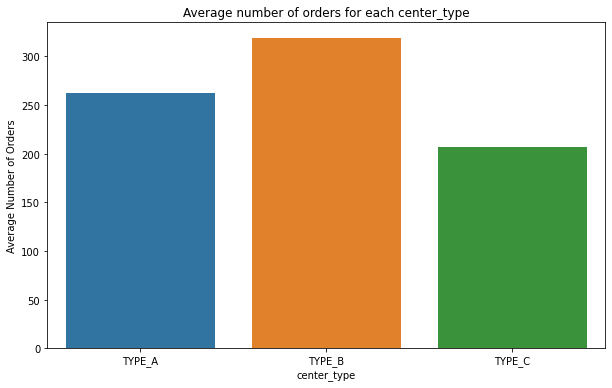

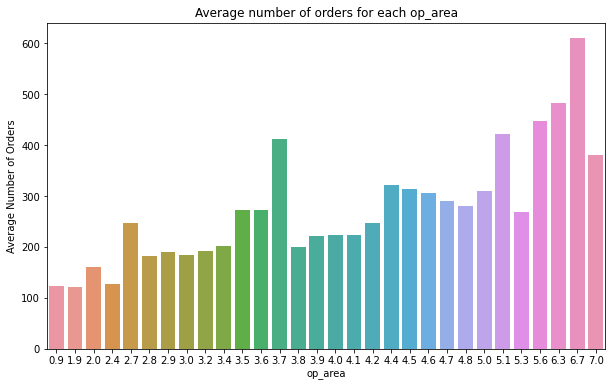

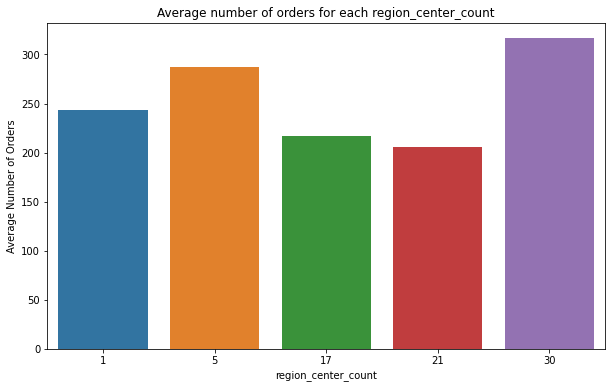

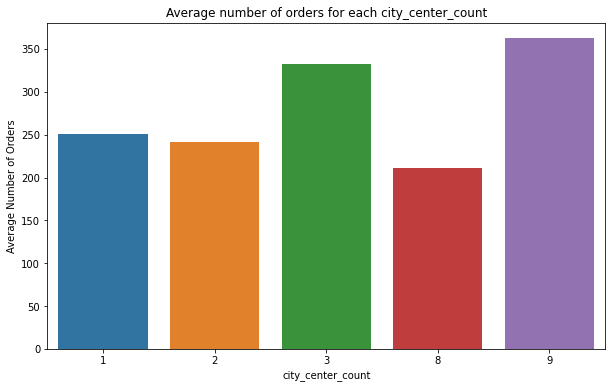

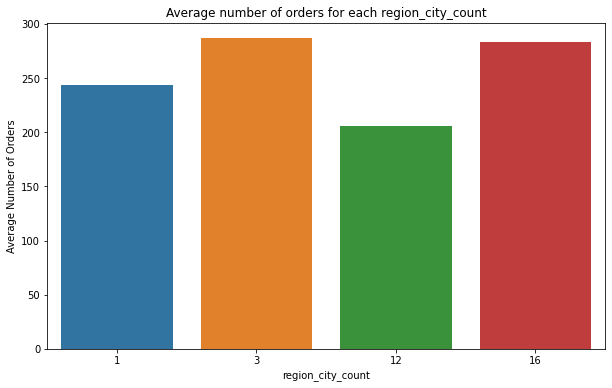

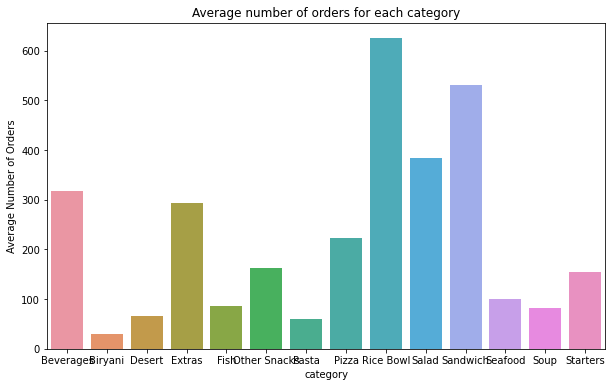

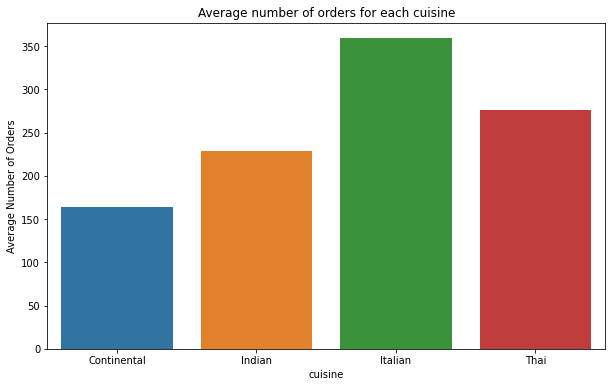

In [10]:
for col in combined_df.columns:
    if col == 'num_orders':
        continue
    data = combined_df.groupby(col)['num_orders'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='num_orders', data=data)
    plt.title(f'Average number of orders for each {col}')
    plt.xlabel(col)
    plt.ylabel('Average Number of Orders')
    plt.show()


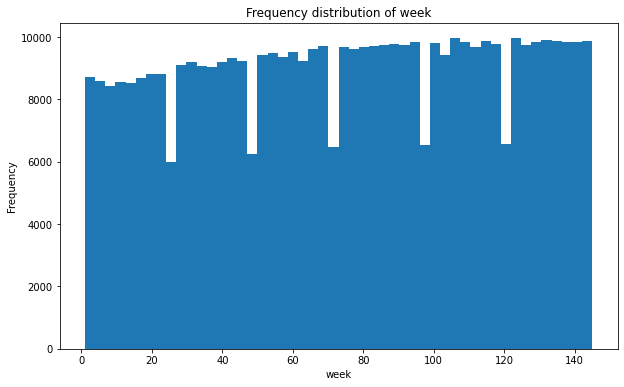

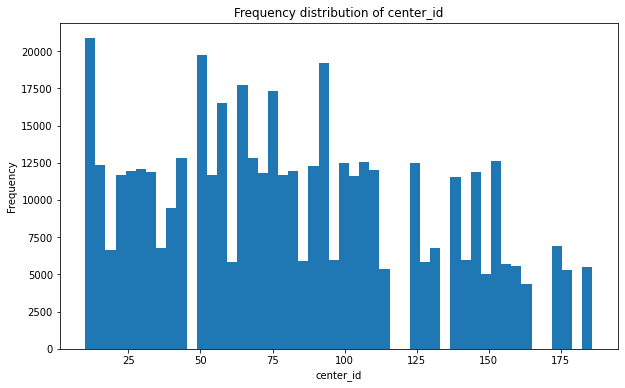

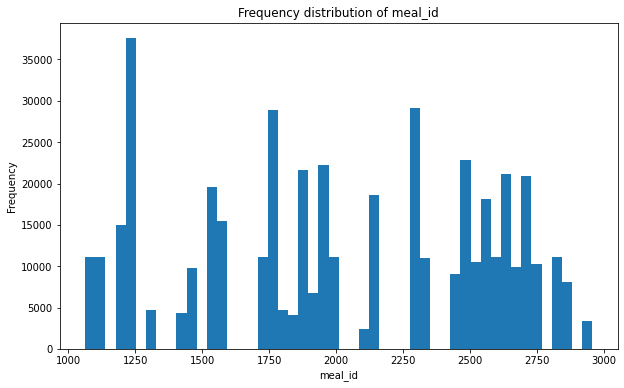

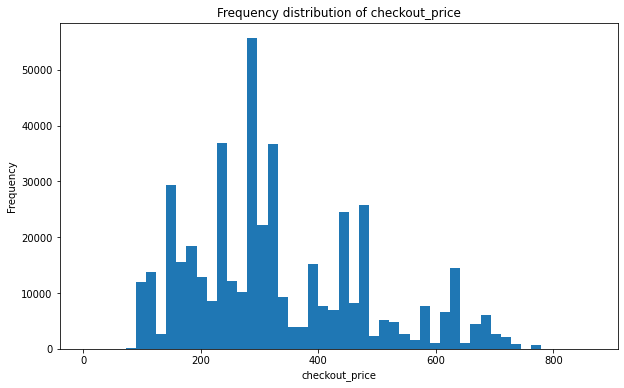

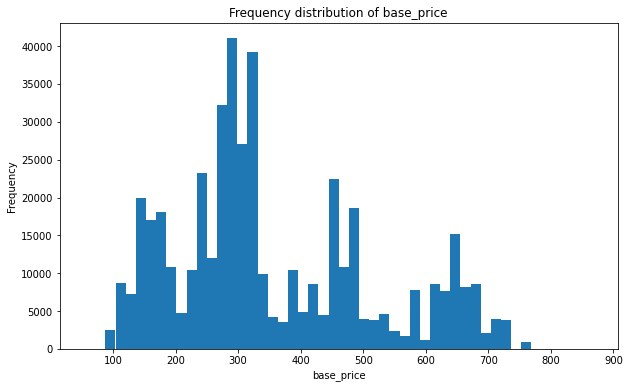

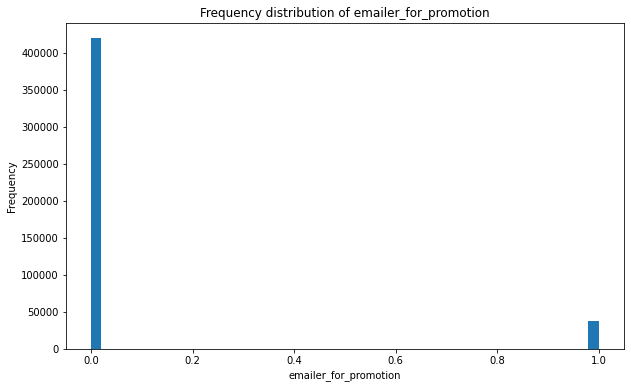

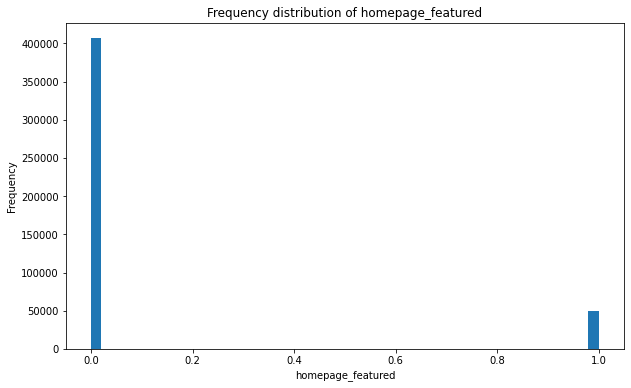

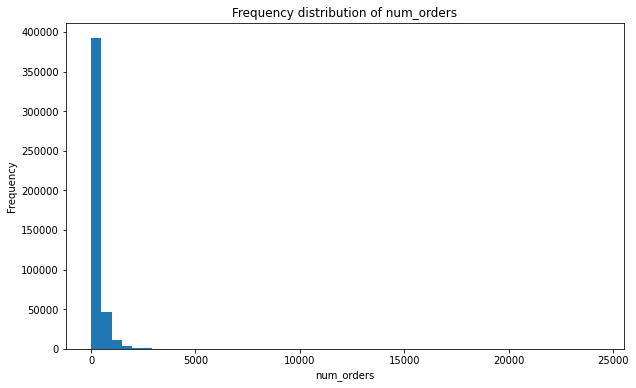

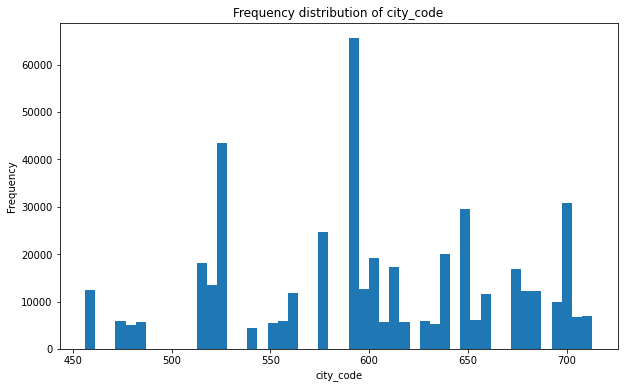

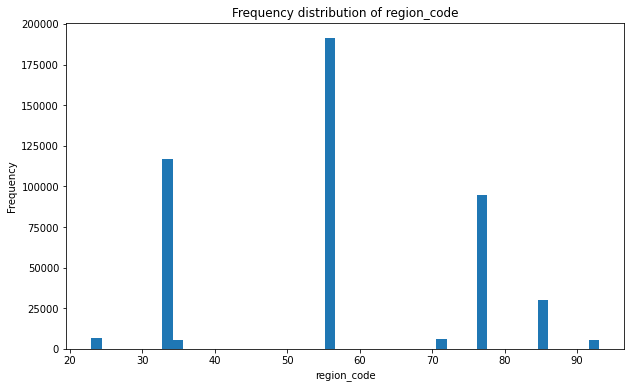

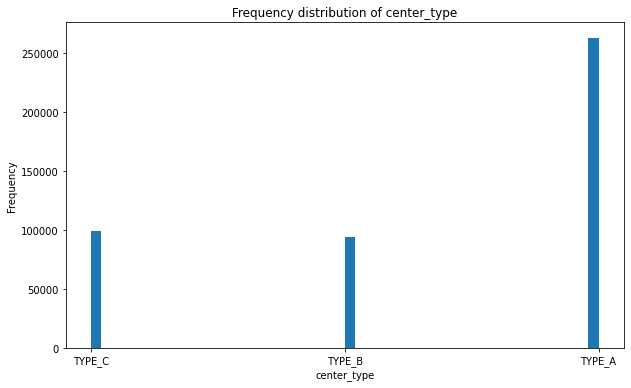

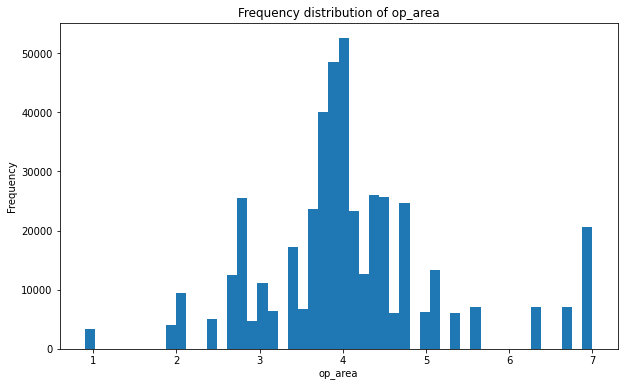

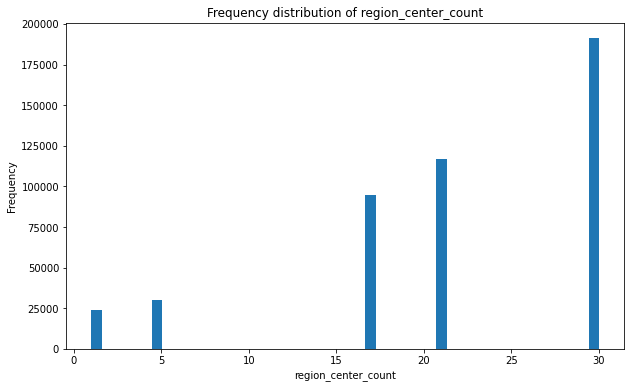

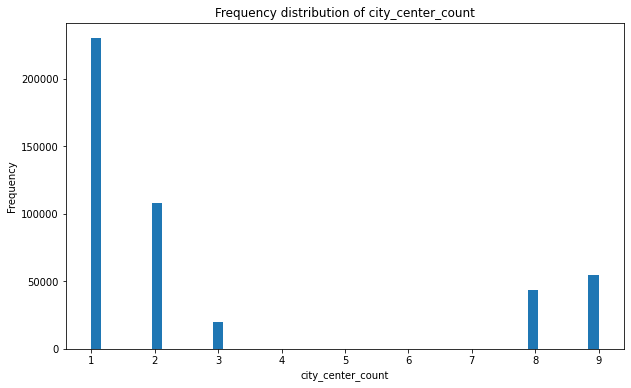

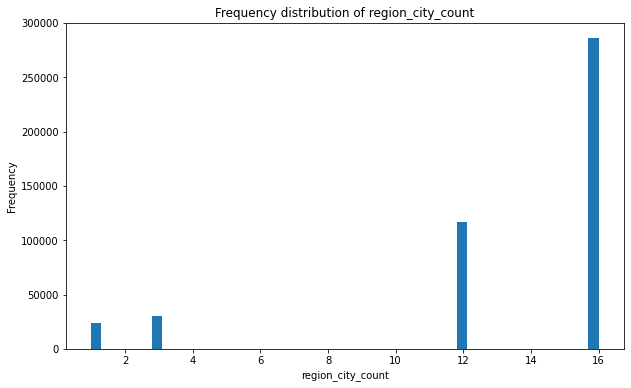

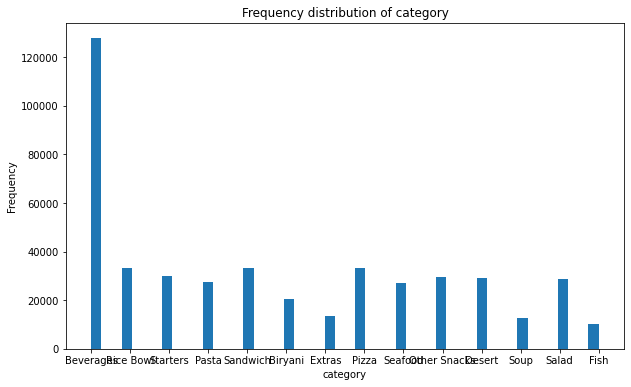

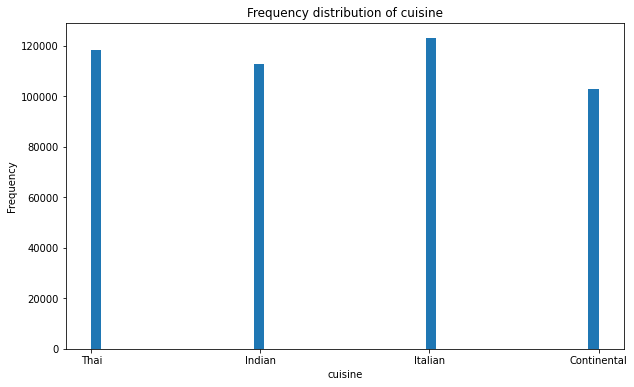

In [11]:
for col in combined_df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(combined_df[col].dropna(), bins=50)  # dropna() to remove any NaN values, bins for number of bins in the histogram
    plt.title(f'Frequency distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


# Creating Features: Average Weekly orders:
We want to look at new features that could help

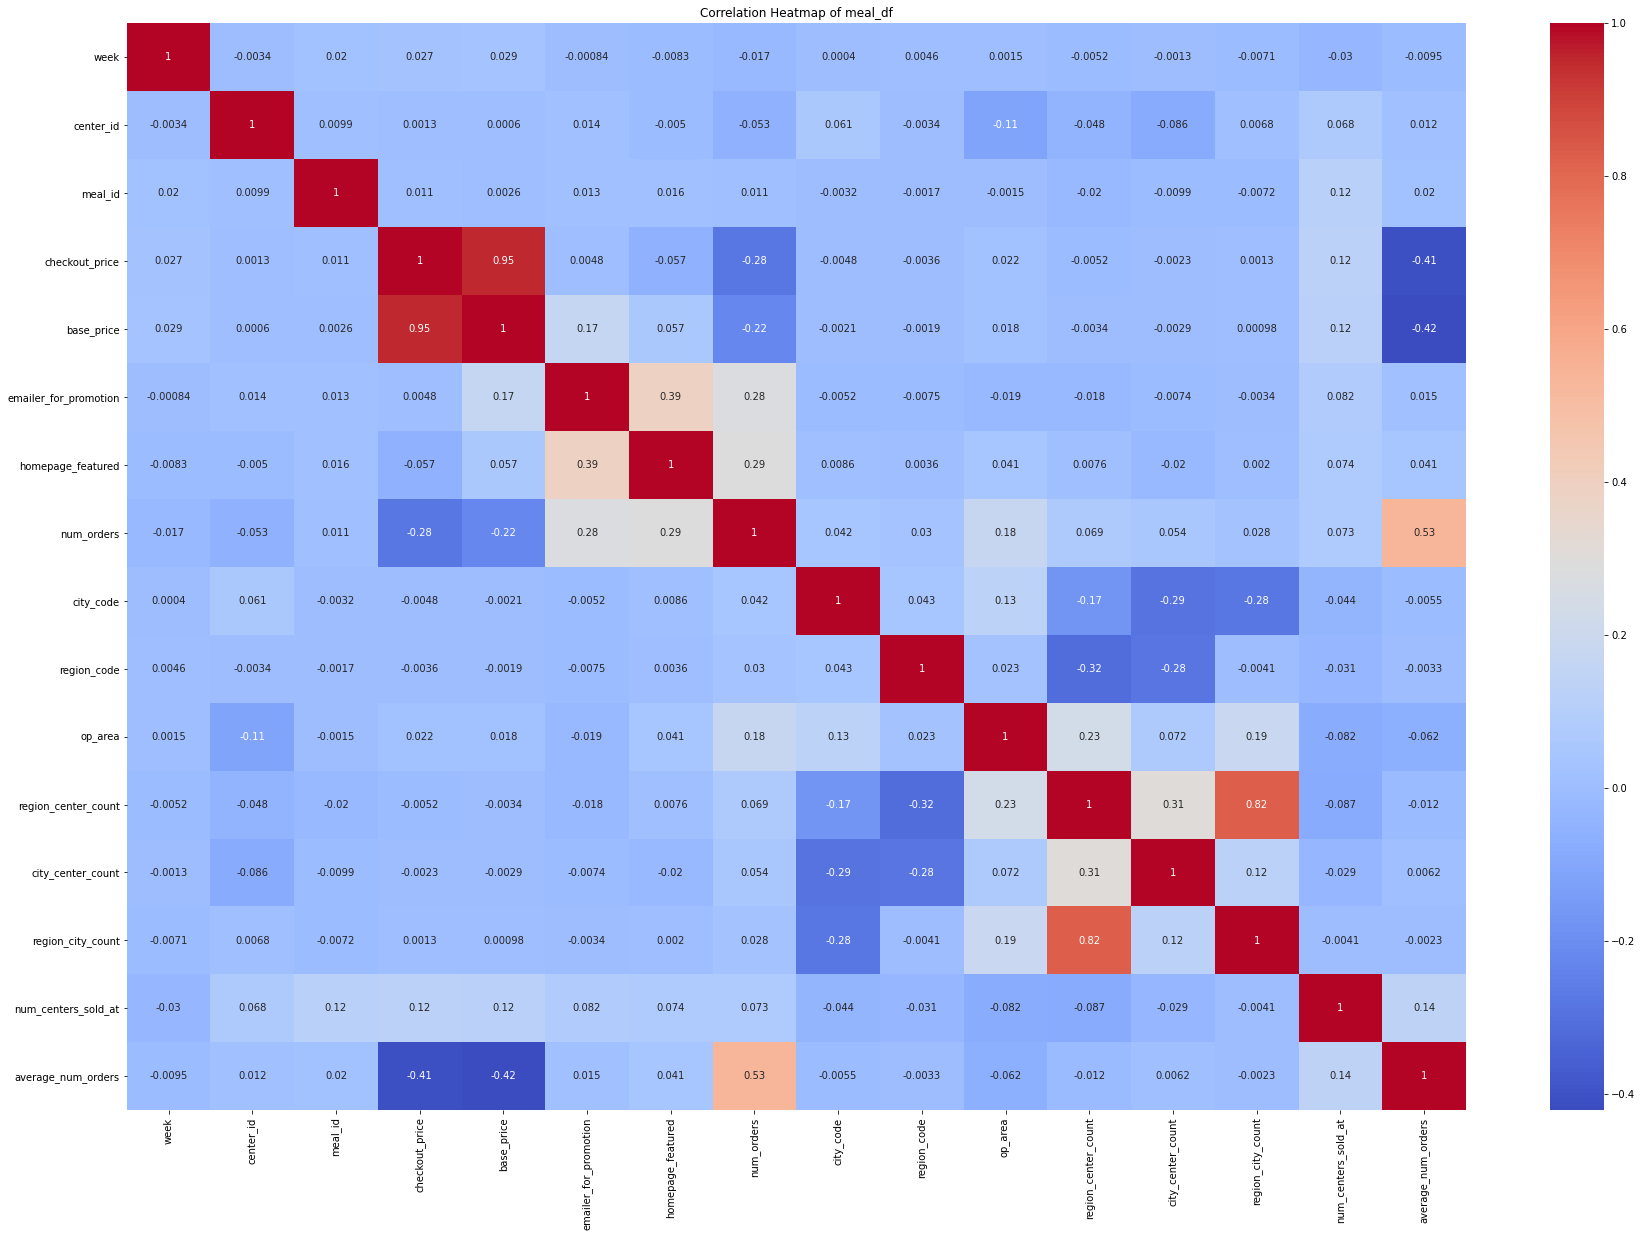

In [12]:
number_sold_at = combined_df.groupby('meal_id').agg(
    num_centers_sold_at=('center_id', 'nunique'),
    average_num_orders=('num_orders', 'mean'),
).reset_index()
combined_df = pd.merge(combined_df, number_sold_at,  on='meal_id', how='left')
plt.figure(figsize=(30, 20))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of meal_df')
plt.show()

# <font color=blue> Testing Models
    

In This section, because the majority of our effort was understanding the method in which we would prepare the data for the model. We began with testing several models, comparing theri performance on the different types of data shapes, the best perfoming data shape and model was then taken for further hyperparamater tweaking

## pipeline functions:

In [13]:
# This dictionary is what we used to understand the different ways we would aggregate the data.
# the key is the column on which we will agregate, and the value are the list of columns to remove when split
remove_when_split_of = {
    'meal_id': ['region_code','city_code','center_id'],
    'region_code' : ['city_code','center_id','meal_id'],
    'city_code' : ['region_code','center_id','meal_id'],
    'center_id': ['region_code','city_code','meal_id'],
    None: ['region_code','city_code','center_id','meal_id'],
    'category': ['region_code','city_code','center_id','meal_id'],
    'cuisine': ['region_code','city_code','center_id','meal_id'],
    'center_type' : ['region_code','city_code','center_id','meal_id']
                       }

In [14]:
# we settled on creating a df using the backtrack method. such that for each feature we choose, and rage of weeks
# go back on, we create a feature for each instance of the value of the previous week. In this method
# if we want to train the model to predict x weeks ahead, we will shift a minimum of x weeks.

def create_backtrack_columns(df, backwards_weeks: list, features_to_collect_backwards = ['num_orders']):
    df = df.sort_values(by=['center_id','meal_id', 'week'])
    for prev_week in backwards_weeks:
        if prev_week == 0:
            continue
            
        for feature_to_collect in features_to_collect_backwards:
            df[f'previous_week{prev_week}_{feature_to_collect}'] = df.groupby('meal_id')[feature_to_collect].shift(prev_week)
    return df



In [15]:

def dummyfy(df, to_dummy=None):
    '''
    This func gets and input of the DF, and a list of columns to dummy
    returns the dummied df after dropping the dummied columns
    '''
    if not to_dummy:
        to_dummy = ['category','cuisine','center_type']
    dummy_dfs = []
    for column in to_dummy:
        dummy_df = pd.get_dummies(df[column], prefix=column)
        dummy_dfs.append(dummy_df)

    # Concatenate the original DataFrame with the dummy-encoded DataFrames
    df = pd.concat([df] + dummy_dfs, axis=1)

    # Drop the original columns if desired
    df = df.drop(to_dummy, axis=1)
    
    
    return df

In [16]:
def prepare_df(df, split_value, columns_to_drop, list_of_weeks_to_backtrack = list(range(1,7)), features_to_backtrack =  ['num_orders']):
    '''
    This functions job is to return a list of dfs to be trained on by a model based on the splitting method we chose
    It performs the removal or irrelevant columns based on split value (taken from dictionary defined above 'remove_when_split_of')
    Based on the value to split, it also creates the dummies and removes nas such that the returning list of dfs
    is clean and ready to train a recuring model
    '''
    
    to_dummy = ['category','cuisine','center_type']

   
    if split_value in to_dummy:
        to_dummy.remove(split_value)
        columns_to_drop.append(split_value)
    df = dummyfy(df,to_dummy)
    df = create_backtrack_columns(df, list_of_weeks_to_backtrack, features_to_backtrack)
    
    # drops al Na for products that are in their intial weeks of selling
    df = df.dropna()
    ### split
    if not split_value:
        df = df.drop(columns = columns_to_drop)
        return [df]
    
    list_of_dfs = []  # empty list to hold dataframes
    for category, group_df in df.groupby(split_value):
        group_df = group_df.drop(columns = columns_to_drop)
        list_of_dfs.append(group_df)

    return list_of_dfs
    

  

In [17]:
''' We had initially considered doing a k-fold model test, but because we had already split the 
data into groups and tested model performance that way, we did not see the gain in using the k-fold method
to test model performance'''

# def run_a_k_fold_model_test(X, y, model):
   
#     k = 5

#     # Initialize a KFold object
#     kf = KFold(n_splits=k, random_state=42, shuffle=True)
    
#     types_of_scalars = [RobustScaler, QuantileTransformer, MinMaxScaler]
#     roi_d = {}
#     for scale in types_of_scalars:
#         print(f'####RUNNING k-fold TEST ON {scale.__name__}######')
#         X_scaled = scale().fit_transform(X)
#         X_scaled = pd.DataFrame(X_scaled, columns=X.columns)   

#         MAE = 0
#         MSE = 0
#         r2 = 0
#         for train_index, test_index in kf.split(X_scaled):
#             X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
#             y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            
#             model_kf = model()
#             model_kf.fit(X_train, y_train)
#             y_pred = model_kf.predict(X_test)
#             r2 += r2_score(y_test,y_pred)
#             MAE += mean_absolute_error(y_test,y_pred)
#             MSE += mean_squared_error(y_test,y_pred)
            

        
#         print("r^2: ", r2/k, " MSE: ", MSE/k, " MAE: ", MAE/k)
        
#     return r2/k, MSE/k, MAE/k

' We had initially considered doing a k-fold model test, but because we had already split the \ndata into groups and tested model performance that way, we did not see the gain in using the k-fold method\nto test model performance'

In [46]:
def run_a_model_test(X, y, model, scaler):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Scale the data train and test separately
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # model must be Initialized in function call to fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, 0, np.inf)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))*100

    # calculate baselin_metric
    y_pred_baseline = np.full((len(y_test), ), y_train.mean())
    r2_basline = r2_score(y_test, y_pred_baseline)
    MAE_baseline = mean_absolute_error(y_test, y_pred_baseline)
    rmsle_baseline = np.sqrt(mean_squared_log_error(y_test, y_pred_baseline))*100

    # Return the metrics
    return (r2, MAE, rmsle), (r2_basline,MAE_baseline,rmsle_baseline)

## The model we tested:

The issue of which hyper parameters we would use, or weather to first choose the parameters and then test the split was a question we considered. But the issue we mostly tried to focus on is how to split/prepare the data for the model. Because on the other hand we could argue that some hyperparameters work better on other splits. For this reason we took hyperparameters using an educated guess, of their performance in previouse projects, to find out which split was the best first!

In [20]:
models = [LinearRegression(),RandomForestRegressor(n_estimators=100, random_state=42), AdaBoostRegressor(n_estimators=100,learning_rate=1)]


## the scalars we tested:
These Scaling methods we looked into, are Standad scalars and Robust scalars, that deal with outliers in a better way than simply minmax scalar, so we decided to test these specifically


In [21]:
scalars = [StandardScaler(), RobustScaler()]

In [114]:
# here we are going to save the final test for the final model
X, FINAL_TEST_X, Y, FINAL_TEST_y = train_test_split(combined_df, combined_df['num_orders'], test_size=0.2, random_state=42)


## <font color=red> Warning very long runtime

In [24]:
# results_df = pd.DataFrame(columns=['r2', 'MAE', 'rmsle', 'r2_basline','MAE_baseline','rmsle_baseline'])
# results_df_2 = pd.DataFrame(columns=['r2', 'MAE', 'rmsle', 'r2_basline','MAE_baseline','rmsle_baseline'])

# for model in models:
   
#     for col_to_split_on, cols_to_remove in remove_when_split_of.items():
#         df_lists = prepare_df(X, col_to_split_on, cols_to_remove)
        
#         for scal in scalars:
#             name=f"{type(model).__name__}_{col_to_split_on}_{type(scal).__name__}"

            
#             for subset_df in df_lists:
                
#                 y = subset_df['num_orders']
#                 x = subset_df.drop(columns='num_orders')
                
#                 results_tup, bsaelin_tup = run_a_model_test(x, y, model, scal)
                
#                 results_df.loc[name] = [*results_tup, *baseline_tup]

                
#             print("\n", results_df.head(-1))
# results.to_csv('results_of_tests.csv') # save run to csv for easier pulling

In [25]:
model_results = pd.read_csv('results_of_tests.csv')
model_results = model_results.drop(columns='Unnamed: 0.1')
model_results = model_results.rename(columns={'Unnamed: 0': 'model_name'})
model_results.columns

Index(['model_name', 'r2', 'MAE', 'rmsle', 'r2_basline', 'MAE_baseline',
       'rmsle_baseline'],
      dtype='object')

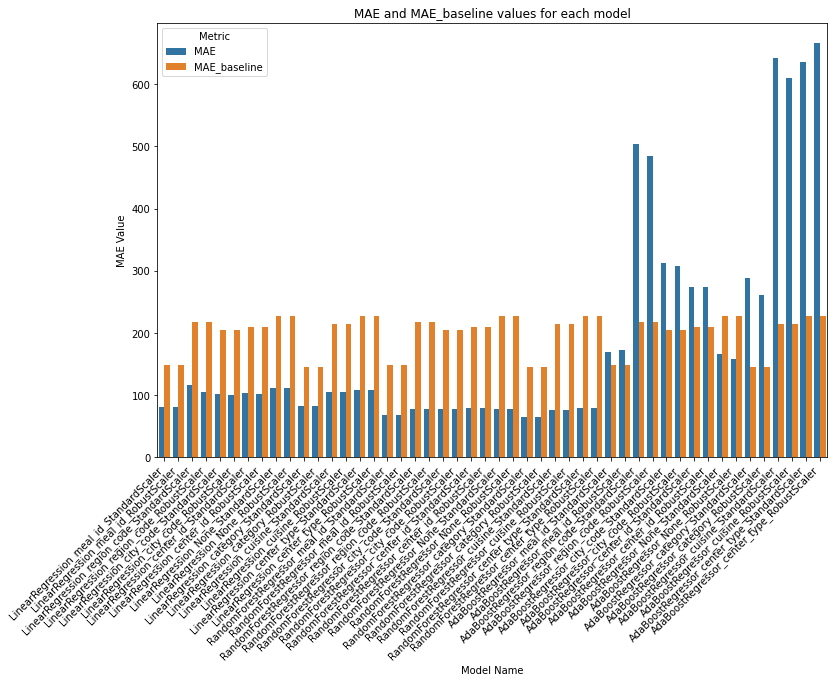

In [26]:

melted_df = model_results.melt(id_vars='model_name', value_vars=['MAE', 'MAE_baseline'])

plt.figure(figsize=(12, 8))
sns.barplot(x='model_name', y='value', hue='variable', data=melted_df)
plt.xlabel('Model Name')
plt.ylabel('MAE Value')
plt.title('MAE and MAE_baseline values for each model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.show()


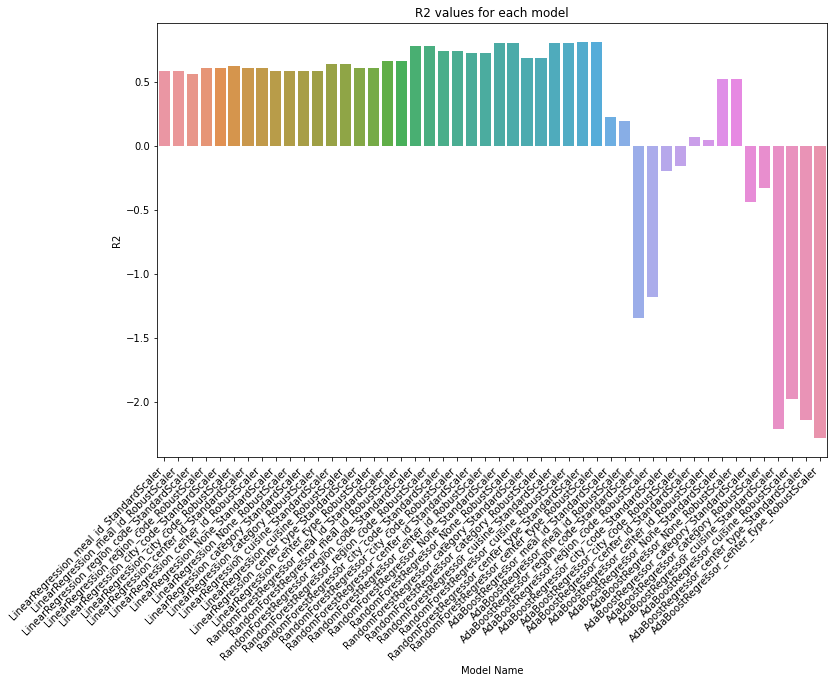

In [27]:

plt.figure(figsize=(12, 8))
sns.barplot(x='model_name', y='r2', data=model_results)
plt.xlabel('Model Name')
plt.ylabel('R2')
plt.title('R2 values for each model')
plt.xticks(rotation=45, ha='right')
plt.show()


In [29]:
model_results.sort_values('MAE')
model_results['Best_MAE_IMPROVEMENT'] = model_results['MAE_baseline'] - model_results['MAE']
model_results.sort_values('MAE')[:10]

,model_name,r2,MAE,rmsle,r2_basline,MAE_baseline,rmsle_baseline,Best_MAE_IMPROVEMENT
26,RandomForestRegressor_category_StandardScaler,0.682252,65.197560,52.179721,-0.000357,144.741978,92.306968,79.544417
27,RandomForestRegressor_category_RobustScaler,0.682287,65.202634,52.183102,-0.000357,144.741978,92.306968,79.539344
16,RandomForestRegressor_meal_id_StandardScaler,0.663720,68.107430,51.502787,-0.000968,147.761477,87.326076,79.654047
17,RandomForestRegressor_meal_id_RobustScaler,0.663612,68.107955,51.505953,-0.000968,147.761477,87.326076,79.653522
28,RandomForestRegressor_cuisine_StandardScaler,0.802863,75.714586,52.879903,-0.000095,214.770844,131.643068,139.056258
29,RandomForestRegressor_cuisine_RobustScaler,0.802991,75.716122,52.879299,-0.000095,214.770844,131.643068,139.054722
20,RandomForestRegressor_city_code_StandardScaler,0.738167,77.062872,53.681263,-0.000935,204.906318,131.167303,127.843445
21,RandomForestRegressor_city_code_RobustScaler,0.738088,77.067667,53.681804,-0.000935,204.906318,131.167303,127.838651
18,RandomForestRegressor_region_code_StandardScaler,0.777033,77.750780,54.641447,-0.000809,218.090893,135.932199,140.340113
19,RandomForestRegressor_region_code_RobustScaler,0.776744,77.802489,54.647389,-0.000809,218.090893,135.932199,140.288404


## As we can see here Adaboost (the last third of the graph) probably did not have enough iterations to learn, as a result and due to lack of time. Now when comparing and deciding which model to use we considered that A higher R2 value indicates that the model explains more of the variance in the data.A lower MAE indicates that the model has better accuracy in predicting the target variable. We care more about accurate predicting then explaining the variance therefore the model with the lowest MAE is the chosen one. 
Although it is interesting to see that some models performed and improved above the baseline more than the best model. As we stated, what we care about is accuracy for our clients.

# The model we chose:
If we were playing with the hyperparameters of all model we  we may have found out that another model or another scaling method or another split on our data is better . Yet it would take us a lot of computing time that we do not have therefore we chose to continue with
* Model: Random Forest Regressor 
* Split on: category 
* Scaler: Standard Scaler

In [138]:
model_results.sort_values('MAE')[:]

,model_name,r2,MAE,rmsle,r2_basline,MAE_baseline,rmsle_baseline,Best_MAE_IMPROVEMENT
26,RandomForestRegressor_category_StandardScaler,0.682252,65.197560,52.179721,-0.000357,144.741978,92.306968,79.544417
27,RandomForestRegressor_category_RobustScaler,0.682287,65.202634,52.183102,-0.000357,144.741978,92.306968,79.539344
16,RandomForestRegressor_meal_id_StandardScaler,0.663720,68.107430,51.502787,-0.000968,147.761477,87.326076,79.654047
17,RandomForestRegressor_meal_id_RobustScaler,0.663612,68.107955,51.505953,-0.000968,147.761477,87.326076,79.653522
28,RandomForestRegressor_cuisine_StandardScaler,0.802863,75.714586,52.879903,-0.000095,214.770844,131.643068,139.056258
29,RandomForestRegressor_cuisine_RobustScaler,0.802991,75.716122,52.879299,-0.000095,214.770844,131.643068,139.054722
20,RandomForestRegressor_city_code_StandardScaler,0.738167,77.062872,53.681263,-0.000935,204.906318,131.167303,127.843445
21,RandomForestRegressor_city_code_RobustScaler,0.738088,77.067667,53.681804,-0.000935,204.906318,131.167303,127.838651
18,RandomForestRegressor_region_code_StandardScaler,0.777033,77.750780,54.641447,-0.000809,218.090893,135.932199,140.340113
19,RandomForestRegressor_region_code_RobustScaler,0.776744,77.802489,54.647389,-0.000809,218.090893,135.932199,140.288404


# Hyperparameterization
The hyperparameters we chose to play with are :
n_estimators: This is the number of trees you want to build before taking the maximum voting or averaging of predictions 
We tried 80-200 jumps of 20 
max_depth: This is the maximum number of levels in each decision tree. 
We treid 10- 60 jumps of 10
min_samples_split: This parameter sets the minimum number of samples required to split an internal node.
We tried 1,5,10,15,20,50,100

We are aware that doing combination of those hyperparmeters checks could have been found a better hyper parameter combination but we are limted with time and computing power therefore we decided to do each one separately.
# <font color=red> Warning following code takes a long time to run

### because the number of estimators best was 180, It took too long to test the rest of the Hyperparameters under this estimator. so we set the n_estimators to 5 so it would run faster.

In [41]:
n_estimators = list(range(80,220,20))
depths = list(range(10,60,10))
min_samples = [1,5,10,15,20,50,100]

In [49]:
results_hyper_est = {}
count = 0
for est in n_estimators:
    model =  RandomForestRegressor(n_estimators=est)
    df_lists = prepare_df(X, 'category', remove_when_split_of['category'])
    scal = StandardScaler()
    
    name=f"{est}_number_trees"
    mae = 0
    for subset_df in df_lists:

        y = subset_df['num_orders']
        x = subset_df.drop(columns='num_orders')

        results_tup, bsaelin_tup = run_a_model_test(x, y, model, scal)
        # in this case we are looking to minimize the MAE.
        mae += results_tup[1]
    results_hyper_est[name] = mae / len(df_lists)
    count += 1
    print(f'completed {count} tests out of {len(n_estimators)}')
results_hyper_est

completed 1 tests out of 7
completed 2 tests out of 7
completed 3 tests out of 7
completed 4 tests out of 7
completed 5 tests out of 7
completed 6 tests out of 7
completed 7 tests out of 7


{'80_number_trees': 65.20018739577583,
 '100_number_trees': 65.06625137465096,
 '120_number_trees': 64.98114741586782,
 '140_number_trees': 64.9819668923432,
 '160_number_trees': 64.98827063181558,
 '180_number_trees': 64.8717075038406,
 '200_number_trees': 64.9417348677183}

In [51]:
sorted_dict = dict(sorted(results_hyper_est.items(), key=lambda item: item[1]))
# Get the first key in the sorted dictionary
best_estimator = next(iter(sorted_dict))
print(f'the best number of trees is ',best_estimator, ' and with mae of ', sorted_dict[best_estimator])


the best number of trees is  180_number_trees  and with mae of  64.8717075038406


best num of trees: 180

In [122]:
best_estimator = 180
results_hyper_depth = {}
count = 0
for deep in depths:
    model =  RandomForestRegressor(n_estimators=best_estimator, max_depth=deep)
    df_lists = prepare_df(X, 'category', remove_when_split_of['category'])
    scal = StandardScaler()
    
    name=f"{deep}_depth"
    mae = 0
    for subset_df in df_lists:

        y = subset_df['num_orders']
        x = subset_df.drop(columns='num_orders')

        results_tup, bsaelin_tup = run_a_model_test(x, y, model, scal)
        # in this case we are looking to minimize the MAE.
        mae += results_tup[1]
    results_hyper_depth[name] = mae / len(df_lists)
    count += 1
    print(f'completed {count} tests out of {len(depths)}  mae is {mae/len(df_lists)}')


completed 1 tests out of 5  mae is 66.50148595392184
completed 2 tests out of 5  mae is 64.88474801622115
completed 3 tests out of 5  mae is 64.94640953322543
completed 4 tests out of 5  mae is 64.88876025005278
completed 5 tests out of 5  mae is 65.00009640121189


### We can see that the smallest MAE reached in our depth test was more than the results of the default value depth. Therefore the final Model will use the default depth value.

In [127]:
results_hyper_depth
sorted_dict = dict(sorted(results_hyper_depth.items(), key=lambda item: item[1]))
# Get the first key in the sorted dictionary
best_depth = int(next(iter(sorted_dict)).split('_')[0])
print(f'the best depth is ',best_depth)

the best depth is  20


In [124]:

results_hyper_missampels = {}
count = 0

for sampl in min_samples:
    model =  RandomForestRegressor(n_estimators=5,max_depth=best_depth,min_samples_leaf=sampl)
    df_lists = prepare_df(X, 'category', remove_when_split_of['category'])
    scal = StandardScaler()
    
    name=f"{sampl}_samples"
    mae = 0
    for subset_df in df_lists:

        y = subset_df['num_orders']
        x = subset_df.drop(columns='num_orders')

        results_tup, bsaelin_tup = run_a_model_test(x, y, model, scal)
        # in this case we are looking to minimize the MAE.
        mae += results_tup[1]
    results_hyper_missampels[name] = mae / len(df_lists)
    count += 1
    print(f'completed {count} tests out of {len(min_samples)} mae is {mae/len(df_lists)}')
results_hyper_missampels
sorted_dict = dict(sorted(results_hyper_missampels.items(), key=lambda item: item[1]))
# Get the first key in the sorted dictionary
best_sample = int(next(iter(sorted_dict)).split('_')[0])


completed 1 tests out of 7 mae is 71.63600364668007
completed 2 tests out of 7 mae is 69.34443206727376
completed 3 tests out of 7 mae is 68.9858808105807
completed 4 tests out of 7 mae is 69.30044313345387
completed 5 tests out of 7 mae is 69.48019545259788
completed 6 tests out of 7 mae is 71.2745549904989
completed 7 tests out of 7 mae is 73.84870375538412


KeyError: 10

In [125]:
results_hyper_missampels

{'1_samples': 71.63600364668007,
 '5_samples': 69.34443206727376,
 '10_samples': 68.9858808105807,
 '15_samples': 69.30044313345387,
 '20_samples': 69.48019545259788,
 '50_samples': 71.2745549904989,
 '100_samples': 73.84870375538412}

### We can see that the smallest MAE reached in our min samples test was more than the results of the default min sample. Therefore the final Model will use the default min_samples value.

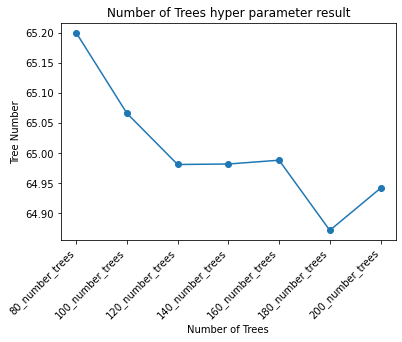

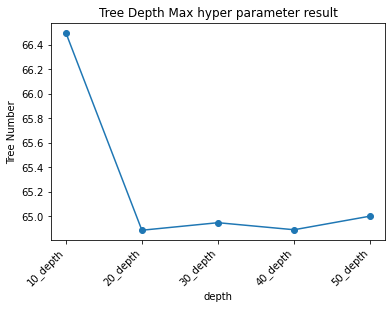

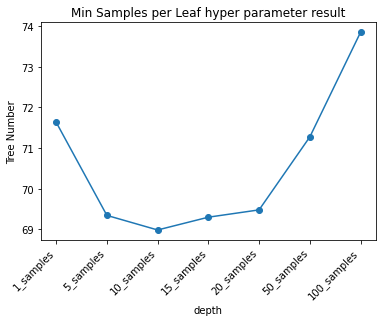

In [126]:
results_hyper_est

x = list(results_hyper_est.keys())
y = list(results_hyper_est.values())

plt.plot(x, y, marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Tree Number')
plt.title('Number of Trees hyper parameter result')
plt.xticks(rotation=45, ha = 'right')
plt.show()

results_hyper_depth

x = list(results_hyper_depth.keys())
y = list(results_hyper_depth.values())

plt.plot(x, y, marker='o')
plt.xlabel('depth')
plt.ylabel('Tree Number')
plt.title('Tree Depth Max hyper parameter result')
plt.xticks(rotation=45, ha = 'right')
plt.show()

results_hyper_missampels

x = list(results_hyper_missampels.keys())
y = list(results_hyper_missampels.values())

plt.plot(x, y, marker='o')
plt.xlabel('depth')
plt.ylabel('Tree Number')
plt.title('Min Samples per Leaf hyper parameter result')
plt.xticks(rotation=45, ha = 'right')
plt.show()


In [129]:
print(f"best num of estimators = {best_estimator} \nbest depth is default \nbest samples per leaf is default")

best num of estimators = 180 
best depth is default 
best samples per leaf is default


# <font color=blue> Final Model Parameters:

In [130]:
best_model = RandomForestRegressor(n_estimators=best_estimator)

# Final Model Test

The method in which we did the final model test, and the test to show how much data was needed to train the model effectively was done this way:
We performed the split on the value we found provided the best results (category) and did the same to the untouched Final_X we split in the begining. For each subset of the X train we trained the 'best' model on the hyperparameters we found and tested on the corresponding (same category) subset in the Final_X test. we then plotted the results.

In [131]:
def prepare_df_final(df, list_of_weeks_to_backtrack = list(range(1,7)), features_to_backtrack =  ['num_orders']):
    '''
    This function much like the prepare df previously used is tailor made for the ideal split we found which is 
    category and returns a dictionary of the df by category name that way we can use it to select the test data 
    aswell
    '''
    split_value = 'category'
    columns_to_drop = ['region_code','city_code','center_id','meal_id']
    to_dummy = ['category','cuisine','center_type']

   
    if split_value in to_dummy:
        to_dummy.remove(split_value)
        columns_to_drop.append(split_value)
    df = dummyfy(df,to_dummy)
    df = create_backtrack_columns(df, list_of_weeks_to_backtrack, features_to_backtrack)
    
    # drops al Na for products that are in their intial weeks of selling
    df = df.dropna()
    
    dfs_dic = {}  # dic to hold dataframes by name
    for category, group_df in df.groupby(split_value):
        group_df = group_df.drop(columns = columns_to_drop)
        dfs_dic[category] = (group_df)

    return dfs_dic
    

      

In [132]:
results = {}
training_sets = prepare_df_final(X)
testing_sets = prepare_df_final(FINAL_TEST_X)

for prop in [.1,.3,.5,.7,1]:
    MAE = 0
    for category_name, traing_df in training_sets.items():
        
        # shuffle the df for safety
        traing_df = traing_df.sample(frac=1)
        # selecting the right df to test
        test_set = testing_sets[category_name]
        # setting the training size to test
        traing_df = traing_df[:int(len(traing_df)*prop)]
        # defining the target and removing it from the X train and test
        y_train = traing_df['num_orders']
        Xtrain = traing_df.drop(columns = 'num_orders')
        
        ytest = test_set['num_orders']
        Xtest = test_set.drop(columns ='num_orders')
        
        # intiating the model
        best_model = RandomForestRegressor(n_estimators=best_estimator,max_depth=best_depth,min_samples_leaf=best_sample)

        # running the model
        best_model.fit(Xtrain,y_train)
        # predicting the Test
        y_pred = best_model.predict(Xtest)
        MAE += mean_absolute_error(ytest, y_pred)
        
    results[prop] = MAE/len(training_sets)
    print(f"prop {prop} is {MAE/len(training_sets)}")
        

        

prop 0.1 is 81.22023497673263
prop 0.3 is 77.5348370253656
prop 0.5 is 76.2402652353441
prop 0.7 is 74.98640053747705
prop 1 is 73.96468454996811


### The cell above was ran by mistake using the non-default hyperparameters, we decided to keep it becuase it is interesting to see that they indeed performed worse that the default parameters used below

In [133]:
results = {}
training_sets = prepare_df_final(X)
testing_sets = prepare_df_final(FINAL_TEST_X)

for prop in [.1,.3,.5,.7,1]:
    MAE = 0
    for category_name, traing_df in training_sets.items():
        
        # shuffle the df for safety
        traing_df = traing_df.sample(frac=1)
        # selecting the right df to test
        test_set = testing_sets[category_name]
        # setting the training size to test
        traing_df = traing_df[:int(len(traing_df)*prop)]
        # defining the target and removing it from the X train and test
        y_train = traing_df['num_orders']
        Xtrain = traing_df.drop(columns = 'num_orders')
        
        ytest = test_set['num_orders']
        Xtest = test_set.drop(columns ='num_orders')
        
        # intiating the model
        best_model = RandomForestRegressor(n_estimators=best_estimator)
        # running the model
        best_model.fit(Xtrain,y_train)
        # predicting the Test
        y_pred = best_model.predict(Xtest)
        MAE += mean_absolute_error(ytest, y_pred)
        
    results[prop] = MAE/len(training_sets)
    print(f"prop {prop} is {MAE/len(training_sets)}")
        

        

prop 0.1 is 80.3144664578482
prop 0.3 is 76.9255975089624
prop 0.5 is 75.82862905557467
prop 0.7 is 74.79530494026153
prop 1 is 73.60962567720567


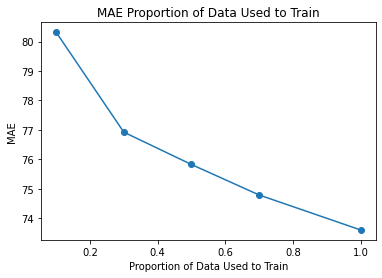

In [137]:
x = list(results.keys())
y = list(results.values())

plt.plot(x, y, marker='o')
plt.xlabel('Proportion of Data Used to Train')
plt.ylabel('MAE')
plt.title('MAE Proportion of Data Used to Train')
plt.show()

# In Conclusion the Final Results of the best model we found under the best hyper parameters was tested on unseen data entirely. What we have seen is that we performed worse that the model performed during the testing and validation stage. This could be a sign of overfitting, but because we tested the results on the average of 14 subsets of the data, it could also be bad luck. Nevertheless, these are our final results. In adition we can see that the main metric swe used to test the goodness of our model: Mean Average Error (MAE) was still in decline as the amount of data provided was 100% for the train was given. Therefore we can say that given more data we expect the model to improve.

# <font color=blue> Feature Importance

24
I have begun
category_name is Beverages
feature imp is [1.80731416e-02 2.31047540e-02 1.44735838e-02 8.76040395e-03
 5.07316579e-03 1.03577756e-02 2.54370475e-03 3.07979832e-03
 1.53705739e-03 3.03514684e-06 6.90490843e-03 1.24725136e-04
 1.32771540e-03 4.71461340e-04 3.14828257e-04 1.05522405e-03
 9.96994627e-04 1.23420806e-03 7.80183666e-01 4.26063967e-02
 2.04073368e-02 1.99147153e-02 1.80819809e-02 1.93694190e-02]
I have begun
category_name is Biryani
feature imp is [0.11171485 0.07621138 0.04360674 0.         0.00099986 0.18870544
 0.01358007 0.02614696 0.00898955 0.         0.02244201 0.
 0.         0.         0.         0.00781553 0.04700269 0.01106784
 0.08158989 0.07470923 0.07747417 0.06955746 0.06984817 0.06853817]
I have begun
category_name is Desert
feature imp is [0.05528239 0.08804114 0.03831377 0.09592786 0.00928123 0.05921724
 0.00860345 0.0245461  0.00587986 0.00221517 0.01010519 0.
 0.         0.         0.         0.00423599 0.02171963 0.00381501
 0.28966601 0.06

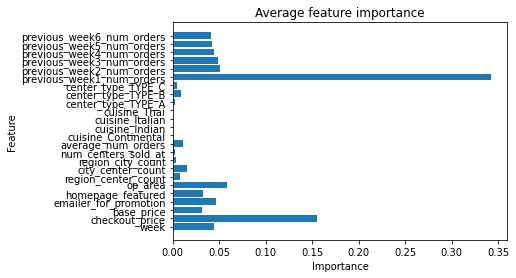

In [165]:
MAE = 0
training_sets = prepare_df_final(X)
testing_sets = prepare_df_final(FINAL_TEST_X)
prop = 1
# all features minus target
accumulated_importances = np.zeros((training_sets['Beverages'].shape[1]) -1 )
print(len(accumulated_importances))
for category_name, traing_df in training_sets.items():
    print('I have begun')
    # shuffle the df for safety
    traing_df = traing_df.sample(frac=1)
    # selecting the right df to test
    test_set = testing_sets[category_name]
    # setting the training size to test
    traing_df = traing_df[:int(len(traing_df))*prop]
    # defining the target and removing it from the X train and test
    y_train = traing_df['num_orders']
    Xtrain = traing_df.drop(columns = 'num_orders')

    ytest = test_set['num_orders']
    Xtest = test_set.drop(columns ='num_orders')

    # initiating the model
    best_model = RandomForestRegressor(n_estimators=best_estimator)
    # running the model
    best_model.fit(Xtrain,y_train)
    # predicting the Test
    y_pred = best_model.predict(Xtest)
    MAE += mean_absolute_error(ytest, y_pred)
    accumulated_importances += best_model.feature_importances_
    print(f'category_name is {category_name}')
    print(f'feature imp is {best_model.feature_importances_}')
    
results[prop] = MAE/len(training_sets)
print(f"prop {prop} is {MAE/len(training_sets)}")

average_importances = accumulated_importances / len(training_sets)
plt.barh(Xtrain.columns, average_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Average feature importance')
plt.show()


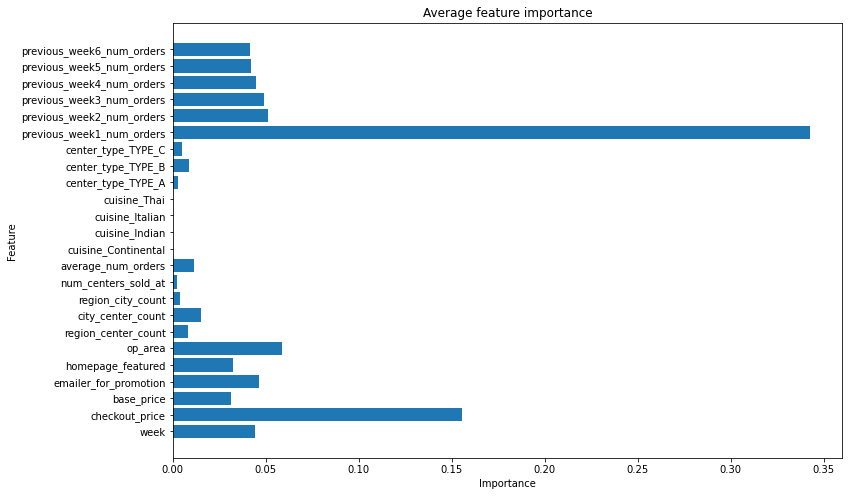

In [167]:
average_importances = accumulated_importances / len(training_sets)
plt.figure(figsize=(12, 8))

plt.barh(Xtrain.columns, average_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Average feature importance')
plt.show()

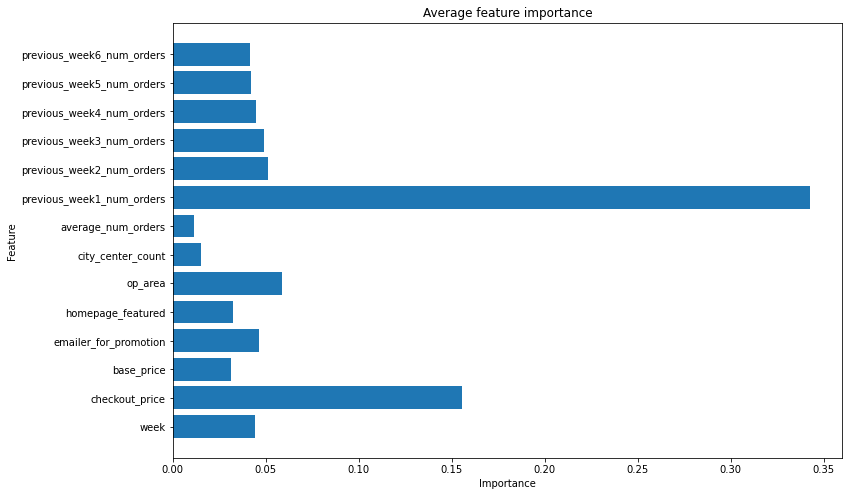

In [168]:
average_importances = accumulated_importances / len(training_sets)

# Create a series with feature names as index
importance_series = pd.Series(average_importances, index=Xtrain.columns)

# Filter the series to only include importances greater than 0.01
filtered_importances = importance_series[importance_series > 0.01]

plt.figure(figsize=(12, 8))
plt.barh(filtered_importances.index, filtered_importances.values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Average feature importance')
plt.show()


# <font color=orange> Out of curiousity. In light of the fact that our final test did not perform that well, we considered the option that the metric we chose (MAE) to measure the best split method was not good enough. To remind you, the lowest MAE had an average R2 score. So what would happen had we chosen the best r2 method of splitting the data (on cuisine) to do the test? how would it have performed?

In [145]:
model_results.sort_values('r2', ascending=False)[:2]

,model_name,r2,MAE,rmsle,r2_basline,MAE_baseline,rmsle_baseline,Best_MAE_IMPROVEMENT
30,RandomForestRegressor_center_type_StandardScaler,0.808148,78.736594,53.881226,-0.000006,226.830646,137.004175,148.094052
31,RandomForestRegressor_center_type_RobustScaler,0.808046,78.732886,53.871121,-0.000006,226.830646,137.004175,148.097760


In [147]:
def prepare_df_final_center(df, list_of_weeks_to_backtrack = list(range(1,7)), features_to_backtrack =  ['num_orders']):
    '''
    This function much like the prepare df previously used is tailor made for the ideal split we found which is 
    category and returns a dictionary of the df by category name that way we can use it to select the test data 
    aswell. yet makde to split of Center
    '''
    split_value = 'center_type'
    columns_to_drop = ['region_code','city_code','center_id','meal_id']
    to_dummy = ['category','cuisine','center_type']

   
    if split_value in to_dummy:
        to_dummy.remove(split_value)
        columns_to_drop.append(split_value)
        
    df = dummyfy(df,to_dummy)
    df = create_backtrack_columns(df, list_of_weeks_to_backtrack, features_to_backtrack)
    
    # drops al Na for products that are in their intial weeks of selling
    df = df.dropna()
    
    dfs_dic = {}  # dic to hold dataframes by name
    for category, group_df in df.groupby(split_value):
        group_df = group_df.drop(columns = columns_to_drop)
        dfs_dic[category] = (group_df)

    return dfs_dic
    

      

In [148]:
results = {}
training_sets = prepare_df_final_center(X)
testing_sets = prepare_df_final_center(FINAL_TEST_X)

for prop in [.1,.3,.5,.7,1]:
    MAE = 0
    for category_name, traing_df in training_sets.items():
        
        # shuffle the df for safety
        traing_df = traing_df.sample(frac=1)
        # selecting the right df to test
        test_set = testing_sets[category_name]
        # setting the training size to test
        traing_df = traing_df[:int(len(traing_df)*prop)]
        # defining the target and removing it from the X train and test
        y_train = traing_df['num_orders']
        Xtrain = traing_df.drop(columns = 'num_orders')
        
        ytest = test_set['num_orders']
        Xtest = test_set.drop(columns ='num_orders')
        
        # intiating the model
        best_model = RandomForestRegressor(n_estimators=best_estimator)
        # running the model
        best_model.fit(Xtrain,y_train)
        # predicting the Test
        y_pred = best_model.predict(Xtest)
        MAE += mean_absolute_error(ytest, y_pred)
        
    results[prop] = MAE/len(training_sets)
    print(f"prop {prop} is {MAE/len(training_sets)}")
        

        

prop 0.1 is 97.24376660665727
prop 0.3 is 92.16062080827224
prop 0.5 is 90.12746465944004
prop 0.7 is 89.42337556198754
prop 1 is 88.06716355266003


## We can say that using the MAE to measure the model did produce the better MAE.